# Credit Card Fraud Detection

The previous exercises made you take a closer look at all the different parts of a neural network: 
* the architecture of a sequential Dense Neural Network, 
* the compilation method
* the fitting.

Let's now work on a real-life dataset that has **a lot of data**!

**The dataset: `Credit Card Transactions`**

For this open challenge, you will `work with data extracted from credit card transactions`. 

As this is `sensitive data`, only 3 columns are known out of a total 31: the rest have been transformed to `anonymize` them (in fact, they are `PCA projections of initial data`).

The 3 known columns are:

* `TIME`: the time elapsed between the transaction and the first transaction in the dataset
* `AMOUNT`: the amount of the transaction
* `CLASS` (our target): 
    * `0 : valid transaction` 
    * `1 : fraudulent transaction`

❓ **Question** ❓ Start by downloading the dataset:
* on the Kaggle website [here](https://www.kaggle.com/mlg-ulb/creditcardfraud) 
* or from our [URL](https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv) 

Load data to create `X` and `y`

In [1]:
import pandas as pd
import numpy as np
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import Adam


2024-01-31 22:33:04.631186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 22:33:04.937037: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-31 22:33:04.960993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-31 22:33:04.961011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
print(imblearn.__version__)

0.9.1


In [3]:
url= 'https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/creditcard.csv'
data= pd.read_csv(url)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X= data.drop(columns='Class')
y= data['Class']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 1. Rebalancing classes

In [7]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [8]:
Counter(y)

Counter({0: 284315, 1: 492})

☝️ in this `fraud detection` challenge, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We won't be able to detect cases of fraud unless we apply some serious rebalancing strategies!**

❓ **Question** ❓
1. **First**, create three separate splits `Train/Val/Test` from your dataset. It is extremely important to keep validation and testing sets **unbalanced** so that when you evaluate your model, it is done in true conditions, without data leakage. Keep your test set for the very last cell of this notebook!

&nbsp;
2. **Second**, rebalance your training set (and only this one). You have many choices:

- Simply oversample the minority class randomly using plain Numpy functions (not the best option since you are duplicating rows and hence creating data leakage)
- Or use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">**`Synthetic Minority Oversampling Technique - SMOTE`**</a> to generate new datapoints by weighting the existing ones
- In addition, you can also try a <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">**`RandomUnderSampler`**</a> to downsample the majority class a little bit

In [9]:
X_trainn, X_test, y_trainn, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train, X_val, y_train, y_val= train_test_split(X_trainn, y_trainn, test_size=0.3, random_state=42)

In [32]:
oversample = SMOTE()
X_train_balc, y_train_balc= oversample.fit_resample(X_train, y_train)

In [33]:
Counter(y_train_balc)

Counter({0: 159198, 1: 159198})

In [34]:
pd.Series(y_train_balc).value_counts(normalize=True)

0    0.5
1    0.5
Name: Class, dtype: float64

In [11]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [12]:
X_train_oub, y_train_oub = pipeline.fit_resample(X_train, y_train)

In [13]:
pd.Series(y_train_oub).value_counts(normalize=True)

0    0.666667
1    0.333333
Name: Class, dtype: float64

## 2. Neural Network iterations

Now that you have rebalanced your classes, try to fit a neural network to optimize your test score. Feel free to use the following hints:

- Normalize your inputs!
    - Use preferably a [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer inside the model to "pipeline" your preprocessing within your model. 
    - Or use sklearn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) outside of your model, applied your `X_train` and `X_val` and `X_test`.
- Make your model overfit, then regularize  it using:
    - Early Stopping criteria 
    - [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers
    - or [`regularizers`](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) layers
- 🚨 Think carefully about the metrics you want to track and the loss function you want to use!


In [14]:
sscaler= StandardScaler()
sscaler.fit(X_train_oub)

StandardScaler()

In [38]:
# X_train_bc_st= sscaler.transform(X_train_balc)
# X_test_st= sscaler.transform(X_test)
# X_val_st= sscaler.transform(X_val)

In [15]:
X_train_oub_scaled= sscaler.transform(X_train_oub)
X_test_st= sscaler.transform(X_test)
X_val_st= sscaler.transform(X_val)

In [68]:
X_train_bc_st.shape

(318396, 30)

In [16]:
def nn_model():

    model= Sequential()
    model.add(layers.Dense(10, activation='relu', input_dim= 30))
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['Recall', 'Precision'])
    
    return model


In [20]:
es = EarlyStopping(patience=10)
model= nn_model()

history = model.fit(
    X_train_oub_scaled,
    y_train_oub,
    validation_data= (X_val_st, y_val),
    epochs = 100,
    batch_size = 32,  
    callbacks = [es]
)


Epoch 1/100
1493/1493 [==============================] - 4s 2ms/step - loss: 0.1271 - recall: 0.8945 - precision: 0.9620 - val_loss: 0.0371 - val_recall: 0.8614 - val_precision: 0.1445
Epoch 2/100
1493/1493 [==============================] - 3s 2ms/step - loss: 0.0543 - recall: 0.9557 - precision: 0.9865 - val_loss: 0.0280 - val_recall: 0.8515 - val_precision: 0.2062
Epoch 3/100
1493/1493 [==============================] - 3s 2ms/step - loss: 0.0405 - recall: 0.9670 - precision: 0.9898 - val_loss: 0.0192 - val_recall: 0.8614 - val_precision: 0.2780
Epoch 4/100
1493/1493 [==============================] - 3s 2ms/step - loss: 0.0324 - recall: 0.9740 - precision: 0.9918 - val_loss: 0.0234 - val_recall: 0.8614 - val_precision: 0.2071
Epoch 5/100
1493/1493 [==============================] - 3s 2ms/step - loss: 0.0281 - recall: 0.9778 - precision: 0.9915 - val_loss: 0.0179 - val_recall: 0.8614 - val_precision: 0.2493
Epoch 6/100
1493/1493 [==============================] - 3s 2ms/step - loss

In [23]:
score= model.evaluate(X_test_st, y_test)

1781/1781 [==============================] - 2s 855us/step - loss: 0.0225 - recall: 0.8571 - precision: 0.2054


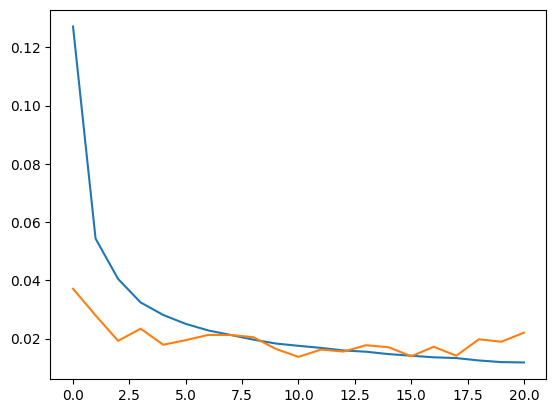

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [24]:
precision= score[]
recall= score[1]

### 🧪 Test your score

Store below your real test performance on a (`X_test`, `y_test`) representative sample of the original unbalanced dataset into `precision` and `recall` variables.

In [ ]:
# YOUR CODE HERE

In [25]:
from nbresult import ChallengeResult

result = ChallengeResult('solution',
    precision=precision,
    recall=recall,
    fraud_number=len(y_test[y_test == 1]),
    non_fraud_number=len(y_test[y_test == 0]),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/parissa/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/parissa/code/ParissaPeimaniyfard/06-Deep-Learning/02-Optimizer-loss-and-fitting/data-credit-card-challenge/tests
plugins: typeguard-2.13.3, anyio-3.6.2, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_solution.py::TestSolution::test_is_score_good_enough FAILED         [ 50%]
test_solution.py::TestSolution::test_is_test_set_representative PASSED   [100%]

=================================== FAILURES ===================================
____________________ TestSolution.test_is_score_good_enough ____________________

self = <tests.test_solution.TestSolution testMethod=test_is_score_good_enough>

    def test_is_score_good_enough(self):
        """Check if the recall result is good enough
        """
>       self.assertGreater(self.r

## 🏁 Optional: Read Google's solution for this challenge
Congratulations for finishing all challenges for this session!

To conclude, take some time to read Google's own solution direcly [on Colab here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb). 

You will discover interesting techniques and best practices